# COMP9517 Project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DeepLabV3+ model

Training set size: 1379 images
Validation set size: 296 images
Test set size: 296 images
加载了 1379 张图像和 1379 张掩码。
加载了 296 张图像和 296 张掩码。
加载了 296 张图像和 296 张掩码。


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


Epoch 1/25, Train Loss: 0.7157068238861259, Val Loss: 0.5003352573043421
Epoch 2/25, Train Loss: 0.4561109457207822, Val Loss: 0.4396946414520866
Epoch 3/25, Train Loss: 0.40634305518248987, Val Loss: 0.421182056790904
Epoch 4/25, Train Loss: 0.3692938942333748, Val Loss: 0.4004368421278502
Epoch 5/25, Train Loss: 0.34579184514352646, Val Loss: 0.4077060771615882
Epoch 6/25, Train Loss: 0.31162315367282123, Val Loss: 0.40222431484021637
Epoch 7/25, Train Loss: 0.28576649502776136, Val Loss: 0.40450657041449295
Epoch 8/25, Train Loss: 0.2722289128892723, Val Loss: 0.41431861331588343
Epoch 9/25, Train Loss: 0.24334548722053395, Val Loss: 0.4142492209610186
Epoch 10/25, Train Loss: 0.22591139256269083, Val Loss: 0.42007984142554433
Epoch 11/25, Train Loss: 0.21386382069395876, Val Loss: 0.4304303338653163
Epoch 12/25, Train Loss: 0.2033439703371333, Val Loss: 0.4341630888612647
Epoch 13/25, Train Loss: 0.20204239449966913, Val Loss: 0.4394356169198689
Epoch 14/25, Train Loss: 0.189883480

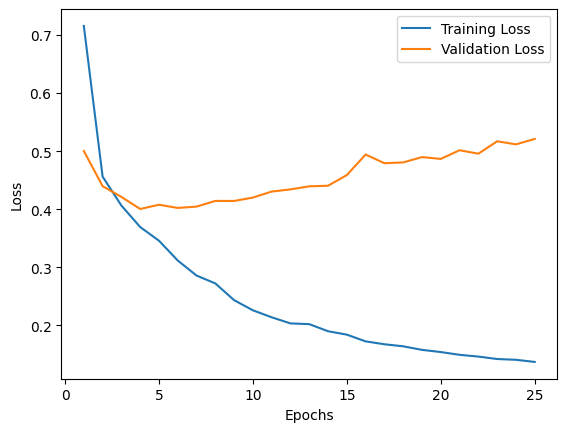

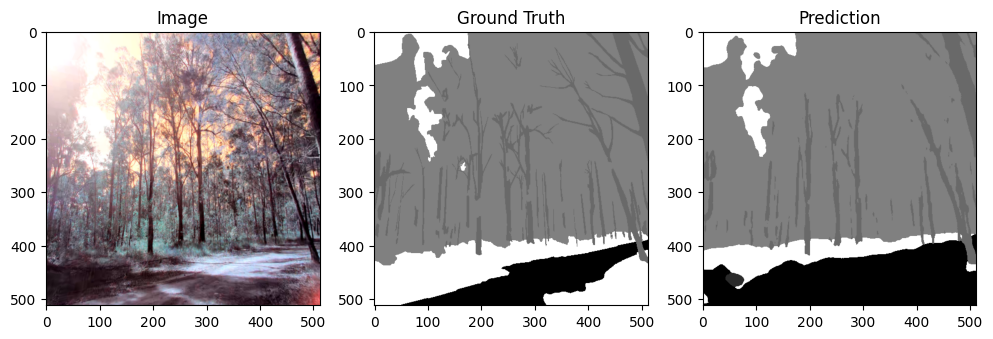

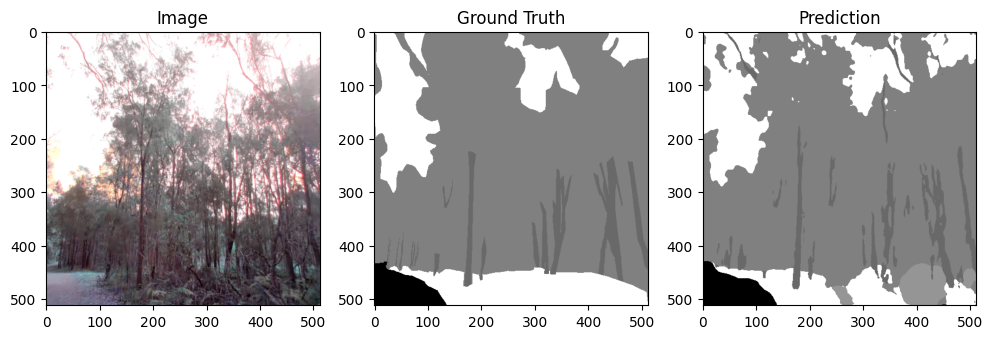

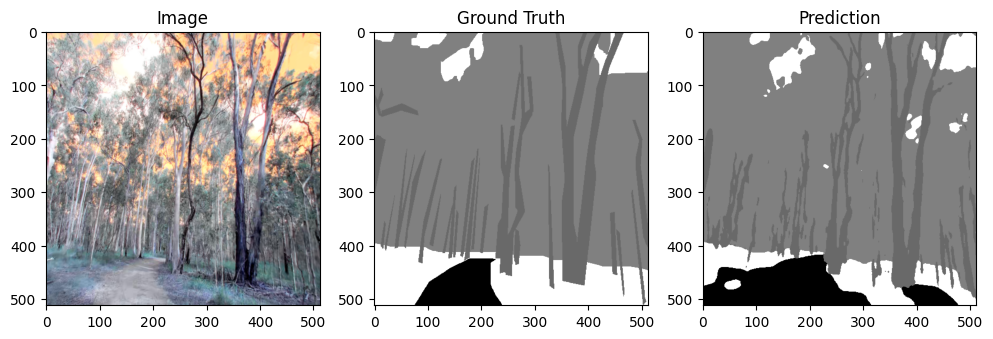

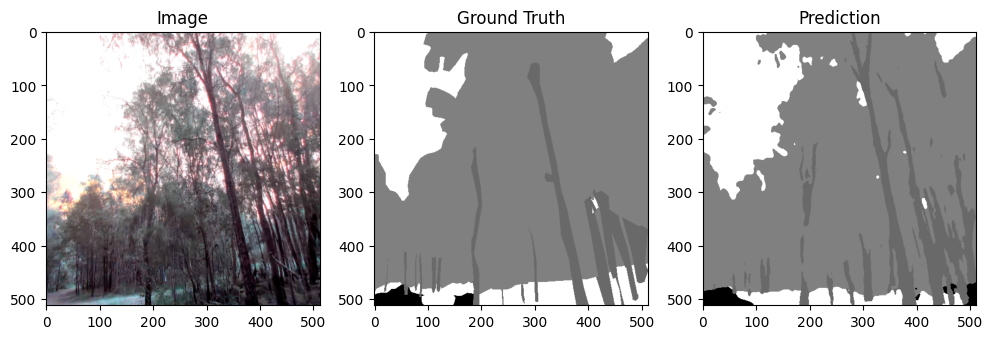

Mean IoU: 5.397226333618164
Model Mean IoU: 5.397226333618164


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc

# Set environment variable to synchronize CUDA errors
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Clean up memory
gc.collect()
torch.cuda.empty_cache()

class WildScenesDataset(Dataset):
    def __init__(self, img_dir, mask_dir, imgs, masks, img_transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.imgs = imgs
        self.masks = masks
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.images = []
        self.preprocessed_masks = []

        # Preprocess images and masks
        for img_name in self.imgs:
            img_path = os.path.join(self.img_dir, img_name)
            image = cv2.imread(img_path)
            if self.img_transform:
                image = self.img_transform(image)
            self.images.append(image)

        for mask_name in self.masks:
            mask_path = os.path.join(self.mask_dir, mask_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if self.mask_transform:
                mask = self.mask_transform(mask)
            self.preprocessed_masks.append(mask)

        print(f"Loaded {len(self.images)} images and {len(self.preprocessed_masks)} masks.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.preprocessed_masks[idx]
        return image, mask

def mask_transform(mask):
    # Resize the mask to 512x512 and convert to tensor
    mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
    mask = torch.tensor(mask, dtype=torch.long)
    mask = torch.clamp(mask, 0, 14)  # Clamp mask values to the range [0, 14]
    return mask

img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Example usage
image_paths = sorted(os.listdir(r'./drive/MyDrive/ColabNotebooks/K-01/image'))
mask_paths = sorted(os.listdir(r'./drive/MyDrive/ColabNotebooks/K-01/indexLabel'))

# Split the data into training, validation, and test sets
train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)

print(f"Training set size: {len(train_images)} images")
print(f"Validation set size: {len(val_images)} images")
print(f"Test set size: {len(test_images)} images")

def create_dataset(image_list, mask_list, image_dir, mask_dir, img_transform, mask_transform):
    dataset = WildScenesDataset(
        img_dir=image_dir,
        mask_dir=mask_dir,
        imgs=image_list,
        masks=mask_list,
        img_transform=img_transform,
        mask_transform=mask_transform
    )
    return dataset

# Create datasets and data loaders
train_dataset = create_dataset(train_images, train_masks, r'./drive/MyDrive/ColabNotebooks/K-01/image', r'./drive/MyDrive/ColabNotebooks/K-01/indexLabel', img_transform, mask_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)  # Increase batch size and enable multi-threaded data loading

val_dataset = create_dataset(val_images, val_masks, r'./drive/MyDrive/ColabNotebooks/K-01/image', r'./drive/MyDrive/ColabNotebooks/K-01/indexLabel', img_transform, mask_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)  # Increase batch size and enable multi-threaded data loading

test_dataset = create_dataset(test_images, test_masks, r'./drive/MyDrive/ColabNotebooks/K-01/image', r'./drive/MyDrive/ColabNotebooks/K-01/indexLabel', img_transform, mask_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)  # Increase batch size and enable multi-threaded data loading

class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=21):
        super(DeepLabV3Plus, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.aspp = ASPP(2048, 256)
        self.decoder = Decoder(256, 256, num_classes)

    def forward(self, x):
        low_level_features = self.backbone.layer1(self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x))))
        x = self.backbone.layer4(self.backbone.layer3(self.backbone.layer2(low_level_features)))
        x = self.aspp(x)
        x = self.decoder(x, low_level_features)
        return x

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6)
        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12)
        self.conv7 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.concat_conv = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1)

    def forward(self, x):
        size = x.size()[2:]  # Get spatial dimensions (height, width)

        conv1 = self.conv1(x)
        conv3 = self.conv3(x)
        conv5 = self.conv5(x)
        conv7 = self.conv7(x)

        global_avg_pool = self.global_avg_pool(x)
        global_avg_pool = self.conv1x1(global_avg_pool)
        global_avg_pool = nn.functional.interpolate(global_avg_pool, size=size, mode='bilinear', align_corners=True)

        x = torch.cat([conv1, conv3, conv5, conv7, global_avg_pool], dim=1)
        x = self.concat_conv(x)
        return x



class Decoder(nn.Module):
    def __init__(self, in_channels, low_level_channels, num_classes):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(low_level_channels, 48, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels + 48, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x, low_level_features):
        low_level_features = self.conv1(low_level_features)
        x = nn.functional.interpolate(x, size=low_level_features.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, low_level_features], dim=1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x
def train_model(model, train_loader, val_loader, num_epochs=25):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # Use AdamW optimizer
    scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Enable mixed precision training
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                with torch.cuda.amp.autocast():  # Enable mixed precision training
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Save model checkpoint
        torch.save(model.state_dict(), f'deeplab_model_epoch_{epoch + 1}.pth')

        # Clear memory
        gc.collect()
        torch.cuda.empty_cache()

    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, test_loader, num_classes=15, save_predictions=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    iou_scores = np.zeros(num_classes, dtype=np.float32)

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for j in range(num_classes):
                intersection = torch.sum((preds == j) & (masks == j)).item()
                union = torch.sum((preds == j) | (masks == j)).item()
                if union != 0:
                    iou_scores[j] += intersection / union

            if save_predictions:
                # Save a few predictions for visualization
                if i < 5:  # Save the first 5 batches
                    for k in range(images.size(0)):
                        image = images[k].cpu().numpy().transpose(1, 2, 0)
                        mask = masks[k].cpu().numpy()
                        pred = preds[k].cpu().numpy()

                        plt.figure(figsize=(12, 4))
                        plt.subplot(1, 3, 1)
                        plt.title('Image')
                        plt.imshow(image)

                        plt.subplot(1, 3, 2)
                        plt.title('Ground Truth')
                        plt.imshow(mask, cmap='gray')

                        plt.subplot(1, 3, 3)
                        plt.title('Prediction')
                        plt.imshow(pred, cmap='gray')

                        plt.savefig(f'prediction_{i}_{k}.png')
                        plt.close()

    mean_iou = np.mean(iou_scores)
    print(f'Mean IoU: {mean_iou}')
    return mean_iou

# Clean up memory
gc.collect()
torch.cuda.empty_cache()

# Train the model
deeplab_model = DeepLabV3Plus(num_classes=15)
train_model(deeplab_model, train_loader, val_loader, num_epochs=25)

# Clean up memory
gc.collect()
torch.cuda.empty_cache()

# Evaluate the model and save prediction results
iou_score = evaluate_model(deeplab_model, test_loader, save_predictions=True)
print(f'Model Mean IoU: {iou_score}')



# U-net model

Training set size: 1379 images
Validation set size: 296 images
Test set size: 296 images
加载了 1379 张图像和 1379 张掩码。
加载了 296 张图像和 296 张掩码。
加载了 296 张图像和 296 张掩码。
Epoch 1/25, Train Loss: 1.814243923658612, Val Loss: 1.4862604203977083
Epoch 2/25, Train Loss: 1.3264966600242702, Val Loss: 1.2211755012211047
Epoch 3/25, Train Loss: 1.1013801125274307, Val Loss: 1.0138213571749235
Epoch 4/25, Train Loss: 0.9290108221700821, Val Loss: 0.8800203517863625
Epoch 5/25, Train Loss: 0.8014144143838992, Val Loss: 0.7444222757690832
Epoch 6/25, Train Loss: 0.700069892680508, Val Loss: 0.669514470978787
Epoch 7/25, Train Loss: 0.6353582965916601, Val Loss: 0.6171033068707115
Epoch 8/25, Train Loss: 0.5767343691710768, Val Loss: 0.5611157527095393
Epoch 9/25, Train Loss: 0.5323156207457356, Val Loss: 0.5281878803905687
Epoch 10/25, Train Loss: 0.5021138156967602, Val Loss: 0.494311450343383
Epoch 11/25, Train Loss: 0.4747931268708459, Val Loss: 0.5064466627020585
Epoch 12/25, Train Loss: 0.457376222500855

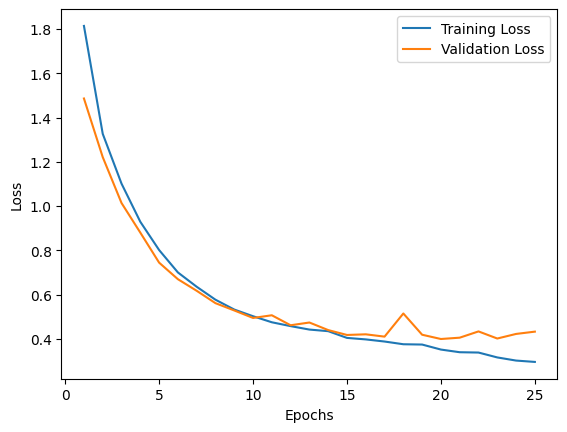

Mean IoU: 4.727787494659424
Model Mean IoU: 4.727787494659424


In [9]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc

# Set environment variable to synchronize CUDA errors
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Clear memory to avoid potential memory issues
gc.collect()
torch.cuda.empty_cache()

# Custom dataset class for handling wild scene images and their corresponding masks
class WildScenesDataset(Dataset):
    def __init__(self, img_dir, mask_dir, imgs, masks, img_transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.imgs = imgs
        self.masks = masks
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.images = []
        self.preprocessed_masks = []

        # Preprocess images
        for img_name in self.imgs:
            img_path = os.path.join(self.img_dir, img_name)
            image = cv2.imread(img_path)
            if self.img_transform:
                image = self.img_transform(image)
            self.images.append(image)

        # Preprocess masks
        for mask_name in self.masks:
            mask_path = os.path.join(self.mask_dir, mask_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if self.mask_transform:
                mask = self.mask_transform(mask)
            self.preprocessed_masks.append(mask)

        print(f"Loaded {len(self.images)} images and {len(self.preprocessed_masks)} masks.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.preprocessed_masks[idx]
        return image, mask

# Transform function for masks to resize and ensure values are within the expected range
def mask_transform(mask):
    mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
    mask = torch.tensor(mask, dtype=torch.long)
    mask = torch.clamp(mask, 0, 14)
    return mask

# Transform function for images using torchvision transforms
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Define the double convolution block used in the U-Net architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Define the downsampling block used in the U-Net architecture
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Define the upsampling block used in the U-Net architecture
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Define the output convolution block used in the U-Net architecture
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Define the U-Net model architecture
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Example usage
image_paths = sorted(os.listdir(r'./drive/MyDrive/ColabNotebooks/T-01/image'))
mask_paths = sorted(os.listdir(r'./drive/MyDrive/ColabNotebooks/T-01/indexLabel'))

# Split data into training, validation, and test sets
train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)

print(f"Training set size: {len(train_images)} images")
print(f"Validation set size: {len(val_images)} images")
print(f"Test set size: {len(test_images)} images")

# Function to create a dataset instance
def create_dataset(image_list, mask_list, image_dir, mask_dir, img_transform, mask_transform):
    dataset = WildScenesDataset(
        img_dir=image_dir,
        mask_dir=mask_dir,
        imgs=image_list,
        masks=mask_list,
        img_transform=img_transform,
        mask_transform=mask_transform
    )
    return dataset

# Create datasets and data loaders
train_dataset = create_dataset(train_images, train_masks, r'./drive/MyDrive/ColabNotebooks/T-01/image', r'./drive/MyDrive/ColabNotebooks/T-01/indexLabel', img_transform, mask_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = create_dataset(val_images, val_masks, r'./drive/MyDrive/ColabNotebooks/T-01/image', r'./drive/MyDrive/ColabNotebooks/T-01/indexLabel', img_transform, mask_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = create_dataset(test_images, test_masks, r'./drive/MyDrive/ColabNotebooks/T-01/image', r'./drive/MyDrive/ColabNotebooks/T-01/indexLabel', img_transform, mask_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

# Function to train the model
def train_model(model, train_loader, val_loader, num_epochs=25):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # Use AdamW optimizer
    scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Enable mixed precision training
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                with torch.cuda.amp.autocast():  # Enable mixed precision training
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Save model checkpoint
        torch.save(model.state_dict(), f'unet_model_epoch_{epoch + 1}.pth')

        # Clear memory
        gc.collect()
        torch.cuda.empty_cache()

    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to evaluate the model and save prediction results
def evaluate_model(model, test_loader, num_classes=15, save_predictions=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    iou_scores = np.zeros(num_classes, dtype=np.float32)

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for j in range(num_classes):
                intersection = torch.sum((preds == j) & (masks == j)).item()
                union = torch.sum((preds == j) | (masks == j)).item()
                if union != 0:
                    iou_scores[j] += intersection / union

            if save_predictions:
                # Save a few predictions for visualization
                if i < 5:  # Save the first 5 batches
                    for k in range(images.size(0)):
                        image = images[k].cpu().numpy().transpose(1, 2, 0)
                        mask = masks[k].cpu().numpy()
                        pred = preds[k].cpu().numpy()

                        plt.figure(figsize=(12, 4))
                        plt.subplot(1, 3, 1)
                        plt.title('Image')
                        plt.imshow(image)

                        plt.subplot(1, 3, 2)
                        plt.title('Ground Truth')
                        plt.imshow(mask, cmap='gray')

                        plt.subplot(1, 3, 3)
                        plt.title('Prediction')
                        plt.imshow(pred, cmap='gray')

                        plt.savefig(f'prediction_{i}_{k}.png')
                        plt.close()

    mean_iou = np.mean(iou_scores)
    print(f'Mean IoU: {mean_iou}')
    return mean_iou

# Clear memory
gc.collect()
torch.cuda.empty_cache()

# Train the U-Net model
unet_model = UNet(n_channels=3, n_classes=15)
train_model(unet_model, train_loader, val_loader, num_epochs=25)

# Clear memory
gc.collect()
torch.cuda.empty_cache()

# Evaluate the U-Net model and save prediction results
iou_score = evaluate_model(unet_model, test_loader, save_predictions=True)
print(f'Model Mean IoU: {iou_score}')


Below is a comparison of the prediction output by the trained model with the original image and the original mask:

Original image                         indexlabel                                    Prediction

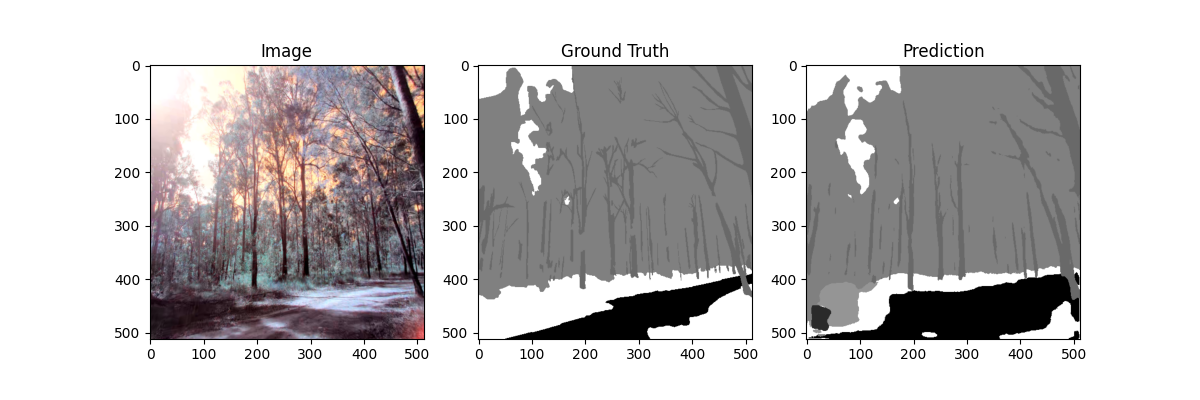

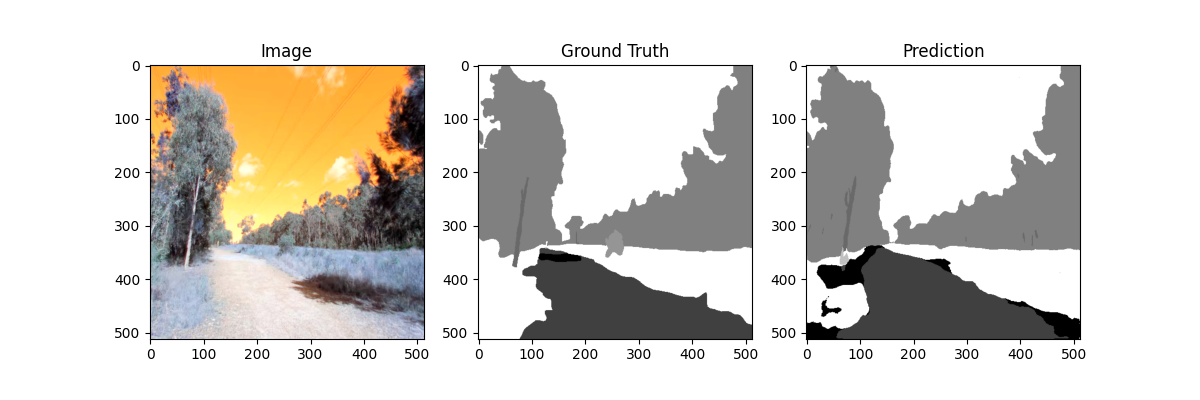

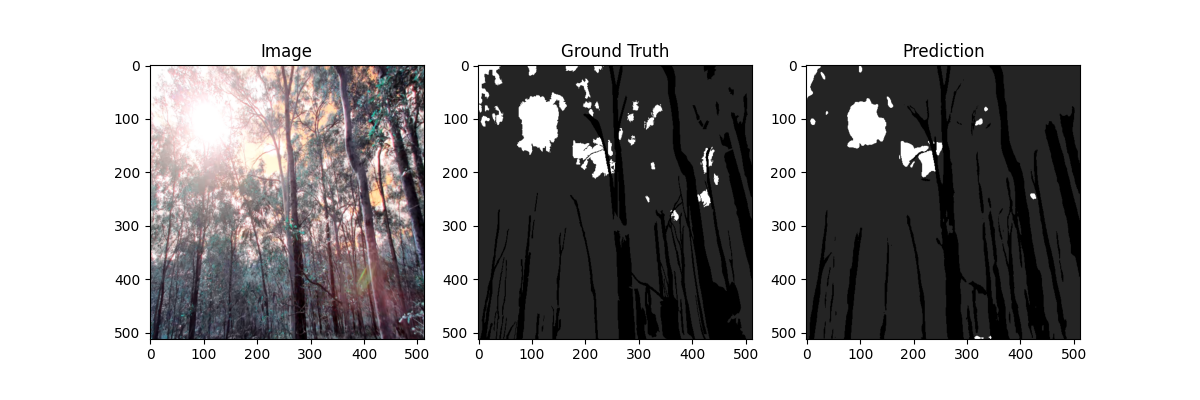

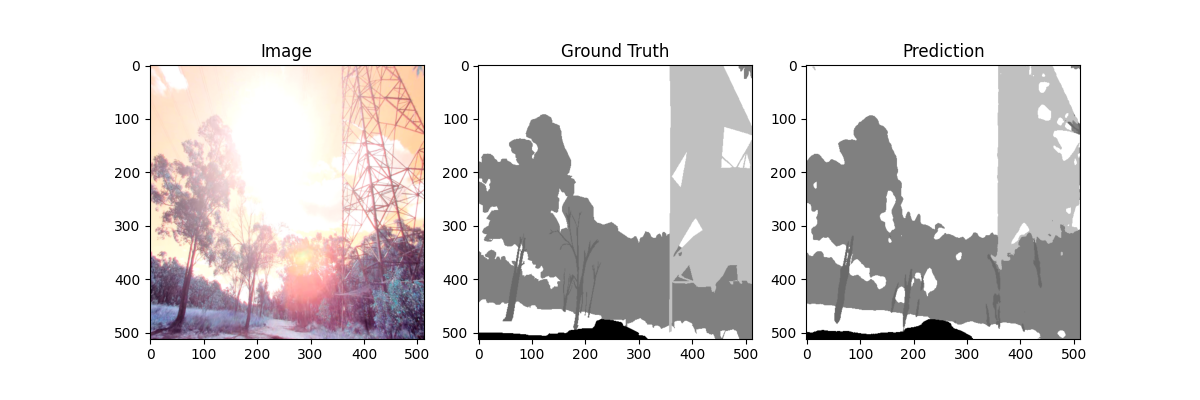

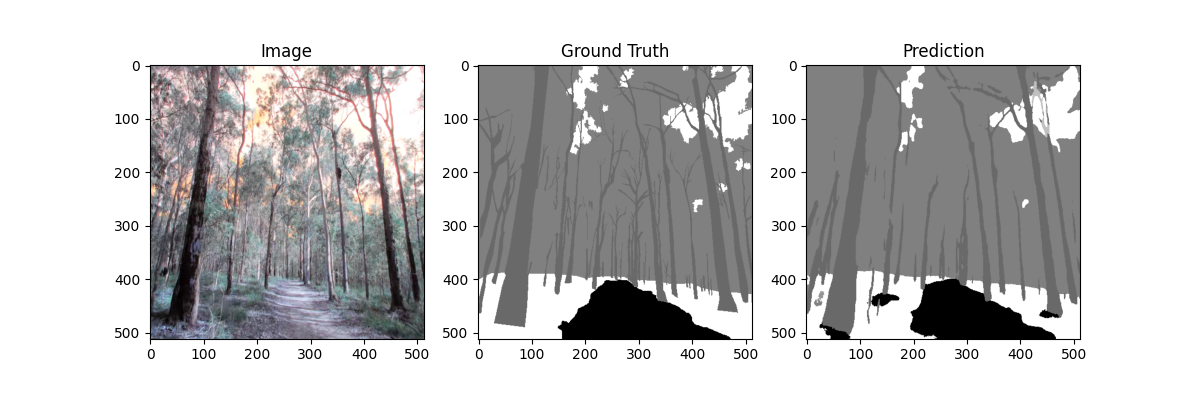

# FCN model

Training set size: 1380 images
Validation set size: 296 images
Test set size: 296 images
Epoch 1/25, Train Loss: 1.9748678275908547, Val Loss: 1.2582019630231356
Epoch 2/25, Train Loss: 1.1870115365105114, Val Loss: 1.2135024886382253
Epoch 3/25, Train Loss: 1.1655702392260234, Val Loss: 1.1967269433172125
Epoch 4/25, Train Loss: 1.1543308962350605, Val Loss: 1.1788968663466604
Epoch 5/25, Train Loss: 1.1297829726646686, Val Loss: 1.1288888517178988
Epoch 6/25, Train Loss: 1.0725798901470227, Val Loss: 1.083630781424673
Epoch 7/25, Train Loss: 1.0223229938539966, Val Loss: 1.025825509899541
Epoch 8/25, Train Loss: 0.9848626447820116, Val Loss: 1.0004184308804964
Epoch 9/25, Train Loss: 0.9665032056556351, Val Loss: 0.9837179058476498
Epoch 10/25, Train Loss: 0.9545895059903463, Val Loss: 0.9713781413279081
Epoch 11/25, Train Loss: 0.9414712999058866, Val Loss: 0.9694954376471671
Epoch 12/25, Train Loss: 0.9316788028026449, Val Loss: 0.9625873251965171
Epoch 13/25, Train Loss: 0.9253935

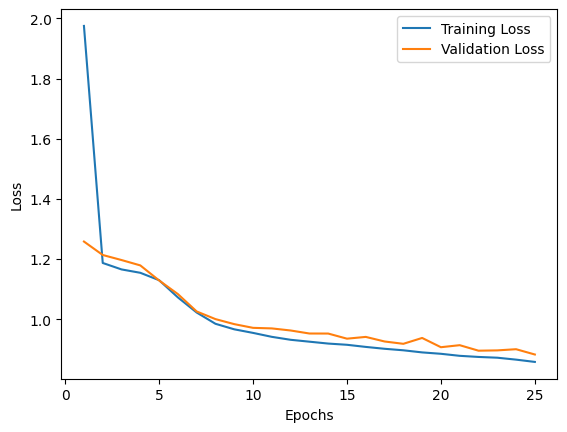

Mean IoU: 1.5562422275543213
Model Mean IoU: 1.5562422275543213


In [ ]:

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc

# Set the environment variable to synchronize CUDA errors
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Clear memory
gc.collect()
torch.cuda.empty_cache()

class WildScenesDataset(Dataset):
    def __init__(self, img_dir, mask_dir, imgs, masks, img_transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.imgs = imgs
        self.masks = masks
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.images = []
        self.preprocessed_masks = []

        # Preprocess images and masks
        for img_name in self.imgs:
            img_path = os.path.join(self.img_dir, img_name)
            image = cv2.imread(img_path)
            if self.img_transform:
                image = self.img_transform(image)
            self.images.append(image)

        for mask_name in self.masks:
            mask_path = os.path.join(self.mask_dir, mask_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if self.mask_transform:
                mask = self.mask_transform(mask)
            self.preprocessed_masks.append(mask)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.preprocessed_masks[idx]
        return image, mask

def mask_transform(mask):
    mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
    mask = torch.tensor(mask, dtype=torch.long)
    mask = torch.clamp(mask, 0, 14)
    return mask

img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Define the FCN model
class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(256, num_classes, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.upsample = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        x = self.upsample(x)
        return x

# Create datasets and data loaders
def create_dataset(image_list, mask_list, image_dir, mask_dir, img_transform, mask_transform):
    dataset = WildScenesDataset(
        img_dir=image_dir,
        mask_dir=mask_dir,
        imgs=image_list,
        masks=mask_list,
        img_transform=img_transform,
        mask_transform=mask_transform
    )
    return dataset

# Split the data into training, validation, and test sets
image_paths = sorted(os.listdir('./drive/MyDrive/ColabNotebooks/K-01/image'))
mask_paths = sorted(os.listdir('./drive/MyDrive/ColabNotebooks/K-01/indexLabel'))

train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)

train_dataset = create_dataset(train_images, train_masks, './drive/MyDrive/ColabNotebooks/K-01/image', './drive/MyDrive/ColabNotebooks/K-01/indexLabel', img_transform, mask_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = create_dataset(val_images, val_masks, './drive/MyDrive/ColabNotebooks/K-01/image', './drive/MyDrive/ColabNotebooks/K-01/indexLabel', img_transform, mask_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = create_dataset(test_images, test_masks, './drive/MyDrive/ColabNotebooks/K-01/image', './drive/MyDrive/ColabNotebooks/K-01/indexLabel', img_transform, mask_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training set size: {len(train_images)} images")
print(f"Validation set size: {len(val_images)} images")
print(f"Test set size: {len(test_images)} images")

# Train and evaluate the model
def train_model(model, train_loader, val_loader, num_epochs=25):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    scaler = torch.cuda.amp.GradScaler()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Save model checkpoint
        torch.save(model.state_dict(), f'fcn_model_epoch_{epoch + 1}.pth')

        # Clear memory
        gc.collect()
        torch.cuda.empty_cache()

    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, test_loader, num_classes=15, save_predictions=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    iou_scores = np.zeros(num_classes, dtype=np.float32)

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for j in range(num_classes):
                intersection = torch.sum((preds == j) & (masks == j)).item()
                union = torch.sum((preds == j) | (masks == j)).item()
                if union != 0:
                    iou_scores[j] += intersection / union

            if save_predictions:
                # Save a few predictions for visualization
                if i < 5:  # Save the first 5 batches
                    for k in range(images.size(0)):
                        image = images[k].cpu().numpy().transpose(1, 2, 0)
                        mask = masks[k].cpu().numpy()
                        pred = preds[k].cpu().numpy()

                        plt.figure(figsize=(12, 4))
                        plt.subplot(1, 3, 1)
                        plt.title('Image')
                        plt.imshow(image)

                        plt.subplot(1, 3, 2)
                        plt.title('Ground Truth')
                        plt.imshow(mask, cmap='gray')

                        plt.subplot(1, 3, 3)
                        plt.title('Prediction')
                        plt.imshow(pred, cmap='gray')

                        plt.savefig(f'prediction_{i}_{k}.png')
                        plt.close()

    mean_iou = np.mean(iou_scores)
    print(f'Mean IoU: {mean_iou}')
    return mean_iou

# Instantiate and train the FCN model
fcn_model = FCN(num_classes=15)
train_model(fcn_model, train_loader, val_loader, num_epochs=25)

# Clear memory
gc.collect()
torch.cuda.empty_cache()

# Evaluate the model and save the prediction results
iou_score = evaluate_model(fcn_model, test_loader, save_predictions=True)
print(f"Model Mean IoU: {iou_score}")


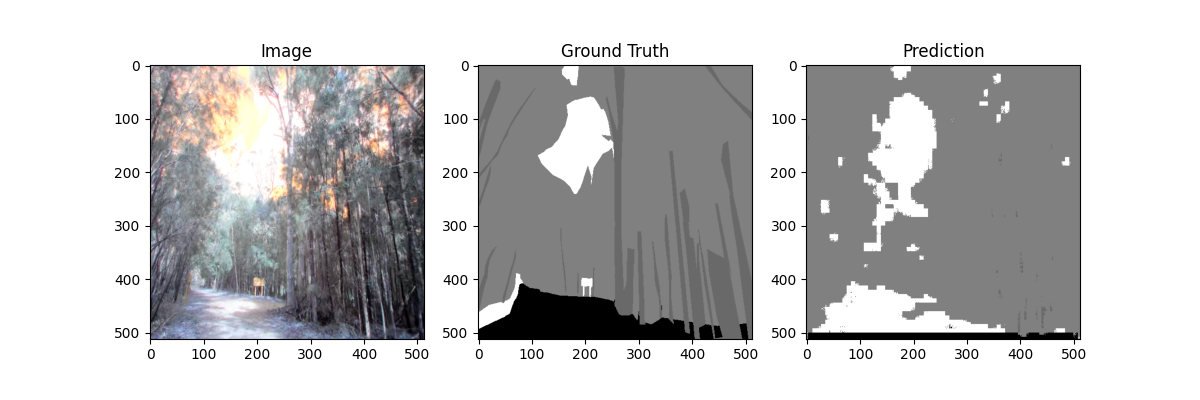

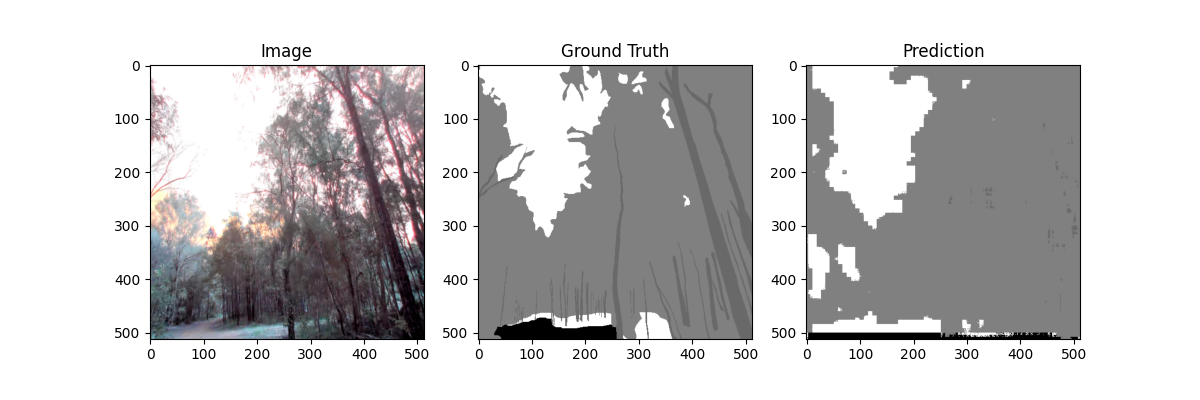

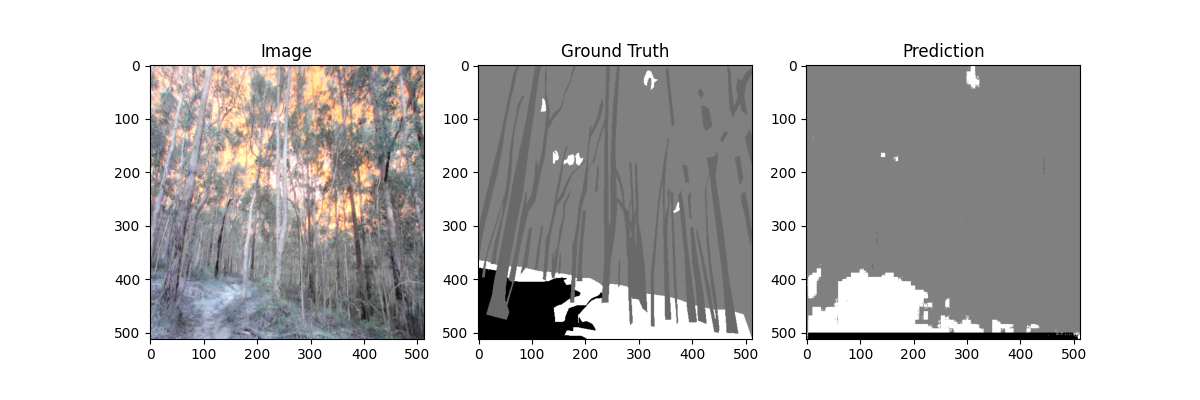